In [ ]:
%%capture

# Mount Google Drive to access files stored there
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

# Clone the IndicTrans2 repository for translation tasks
!git clone https://github.com/AI4Bharat/IndicTrans2.git
# Clone the Punjabi_ASR repository for speech recognition tasks
!git clone https://github.com/kdcyberdude/Punjabi_ASR.git
# Clone the IndicTransTokenizer repository
!git clone https://github.com/VarunGumma/IndicTransTokenizer.git

# Navigate to the IndicTrans2 project's huggingface interface directory
%cd /content/drive/MyDrive/IndicTrans2/huggingface_interface
# Install packages necessary for IndicTrans2
!pip install nltk sacremoses pandas regex mock transformers>=4.33.2 mosestokenizer
!pip install bitsandbytes scipy accelerate datasets sentencepiece
!python3 -c "import nltk; nltk.download('punkt')"

# Navigate to the IndicTransTokenizer project directory
%cd /content/drive/MyDrive/IndicTransTokenizer
!pip install --editable ./

%cd /content/drive/MyDrive/Punjabi_ASR
# Install packages for the Punjabi_ASR project
!pip install matplotlib datasets evaluate transformers rouge_score torchaudio jiwer accelerate PyExecJS indic-num2words librosa soundfile pyctcdecode
!pip install https://github.com/kpu/kenlm/archive/master.zip

# Install Flask and related packages for setting up a web server
!pip install flask flask-cors pyngrok

------------ ------ ------ ------ Loading Models ------ ------ ------ -----------

In [ ]:
import os
import torch
from transformers import Wav2Vec2BertForCTC, pipeline, AutoModelForSeq2SeqLM

os.environ['TRANSFORMERS_CACHE'] = '/content/drive/MyDrive/HF_Cache'
os.environ['HF_DATASETS_CACHE'] = '/content/drive/MyDrive/HF_Cache'

%cd /content/drive/MyDrive/IndicTransTokenizer/
from IndicTransTokenizer import IndicProcessor, IndicTransTokenizer


# Load ASR model and processor
%cd /content/drive/MyDrive/Punjabi_ASR/
import speech_utils as su
from m4t_processor_with_lm import M4TProcessorWithLM

model_id = 'kdcyberdude/w2v-bert-punjabi'
processor = M4TProcessorWithLM.from_pretrained(model_id)
model = Wav2Vec2BertForCTC.from_pretrained(model_id, trust_remote_code=True)

pipe = pipeline('automatic-speech-recognition', model=model, tokenizer=processor.tokenizer, feature_extractor=processor.feature_extractor, decoder=processor.decoder, return_timestamps='word', device='cuda:0')

# Load translation model
%cd /content/drive/MyDrive/IndicTrans2/huggingface_interface/
from transformers import AutoTokenizer
from IndicTransTokenizer import IndicProcessor, IndicTransTokenizer

BATCH_SIZE = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def initialize_model_and_tokenizer(ckpt_dir, direction):
    tokenizer = IndicTransTokenizer(direction=direction)
    model = AutoModelForSeq2SeqLM.from_pretrained(ckpt_dir, trust_remote_code=True, low_cpu_mem_usage=True)

    if DEVICE == "cuda":
        model = model.to(DEVICE)
        model.half()

    model.eval()
    return tokenizer, model

def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip, untranslated_words):
    translations = []
    for i in range(0, len(input_sentences), BATCH_SIZE):
        batch = input_sentences[i: i + BATCH_SIZE]
        print(f"Original batch: {batch}")

        # Apply direct replacements for untranslated words
        batch = [preprocess_for_translation(sentence, untranslated_words) for sentence in batch]
        print(f"Batch after custom preprocessing: {batch}")

        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)
        inputs = tokenizer(batch, src=True, truncation=True, padding="longest", return_tensors="pt", return_attention_mask=True).to(DEVICE)
        try:
            with torch.no_grad():
                generated_tokens = model.generate(**inputs, use_cache=True, min_length=0, max_length=164, num_beams=5, num_return_sequences=1)
            decoded_tokens = tokenizer.batch_decode(generated_tokens.detach().cpu().tolist(), src=False)
            print(f"Decoded tokens: {decoded_tokens}")
        except Exception as e:
            print(f"Error during model generation: {e}")
            continue

        translations += decoded_tokens

        del inputs
        torch.cuda.empty_cache()

    return translations


indic_en_ckpt_dir = "ai4bharat/indictrans2-indic-en-dist-200M"
indic_en_tokenizer, indic_en_model = initialize_model_and_tokenizer(indic_en_ckpt_dir, "indic-en")
ip = IndicProcessor(inference=True)

# Initialize the summarization pipeline
summarization_pipe = pipeline("text2text-generation", model="knkarthick/MEETING-SUMMARY-BART-LARGE-XSUM-SAMSUM-DIALOGSUM")



/content/drive/MyDrive/IndicTransTokenizer
/content/drive/MyDrive/Punjabi_ASR


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

language_model/attrs.json:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

alphabet.json:   0%|          | 0.00/703 [00:00<?, ?B/s]

5gram_pa_3_correct.arpa:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

unigrams.txt:   0%|          | 0.00/15.8M [00:00<?, ?B/s]

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


config.json:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

/content/drive/MyDrive/IndicTrans2/huggingface_interface


<ipython-input-2-86f327f557ac>:32: DeprecationWarning: This IndicTransTokenizer is deprecated.
The official Tokenizer is available on HF and can be used as follows:
```
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
```
  tokenizer = IndicTransTokenizer(direction=direction)


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration_indictrans.py:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-indic-en-dist-200M:
- configuration_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_indictrans.py:   0%|          | 0.00/79.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-indic-en-dist-200M:
- modeling_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/914M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


------------ ------ ------ ------ Integrating Customized Dictionary ------ ------ ------ --------

In [ ]:
import json

# Function to load untranslated words from a JSON file
def load_untranslated_words(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        untranslated_words = json.load(file)
    return untranslated_words

# Load your words from Google Drive
file_path = '/content/drive/MyDrive/personalised_dict.json'
untranslated_words = load_untranslated_words(file_path)

def preprocess_for_translation(text, untranslated_words):
    # Directly replace specific words with their translations
    for punjabi_word, english_translation in untranslated_words.items():
        if punjabi_word in text:
            text = text.replace(punjabi_word, english_translation)
    return text

------------ ------ ------ ------ Evalutaion of ASR in batches ------ ------ ------ -----------

In [ ]:
import os
import pandas as pd
import torch
from datasets import Dataset, Audio
from jiwer import wer


# Define your data directory and load metadata
data_dir = '/content/drive/MyDrive/pa-IN'
metadata_file = os.path.join(data_dir, 'validated.tsv')
metadata = pd.read_csv(metadata_file, sep='\t')

# Prepare data for the Dataset
data = {
    'file_path': [os.path.join(data_dir, 'clips', row['path']) for idx, row in metadata.iterrows()],
    'transcription': [row['sentence'] for idx, row in metadata.iterrows()]
}

# Create a Dataset object and load audio files
dataset = Dataset.from_dict(data).cast_column("file_path", Audio(sampling_rate=16000))

# Evaluation function
def evaluate(pipe, dataset, batch_size=8):
    total_wer = 0
    num_samples = 0

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, collate_fn=lambda x: x)

    for batch in dataloader:
        # Extract audio and transcription data from batch
        input_values = [item['file_path']['array'] for item in batch]
        transcriptions = [item['transcription'] for item in batch]

        # Use the pipeline to process the audio directly
        with torch.no_grad():
            results = pipe(input_values) # Pass audio data directly to pipeline
            predicted_transcriptions = [result["text"] for result in results]

        # Calculate WER for the batch
        batch_wer = wer(transcriptions, predicted_transcriptions)
        total_wer += batch_wer * len(predicted_transcriptions)
        num_samples += len(predicted_transcriptions)

        # Print progress with WER as percentage
        current_wer_percentage = batch_wer * 100
        if num_samples % 10 == 0:
            print(f"Processed {num_samples} files, Current WER: {current_wer_percentage:.2f}%")

    average_wer = total_wer / num_samples
    average_wer_percentage = average_wer * 100
    print(f"Average WER across the dataset: {average_wer_percentage:.2f}%")

# Call the evaluate function
evaluate(pipe, dataset)

Processed 40 files, Current WER: 17.31%
Processed 80 files, Current WER: 7.55%
Processed 120 files, Current WER: 7.41%
Processed 160 files, Current WER: 3.45%
Processed 200 files, Current WER: 28.85%
Processed 240 files, Current WER: 13.33%
Processed 280 files, Current WER: 22.41%
Processed 320 files, Current WER: 13.21%
Processed 360 files, Current WER: 3.45%
Processed 400 files, Current WER: 11.67%
Processed 440 files, Current WER: 11.32%
Processed 480 files, Current WER: 11.11%
Processed 520 files, Current WER: 5.45%
Processed 560 files, Current WER: 4.62%
Processed 600 files, Current WER: 0.00%
Processed 640 files, Current WER: 1.75%
Processed 680 files, Current WER: 1.69%
Processed 720 files, Current WER: 1.52%
Processed 760 files, Current WER: 1.79%
Processed 800 files, Current WER: 1.61%
Processed 840 files, Current WER: 3.70%
Processed 880 files, Current WER: 3.39%
Processed 920 files, Current WER: 0.00%
Processed 960 files, Current WER: 6.56%
Processed 1000 files, Current WER:

In [ ]:
------------ ------ ------ ------ Visualizing results of the ASR model ------ ------ ------ -----------

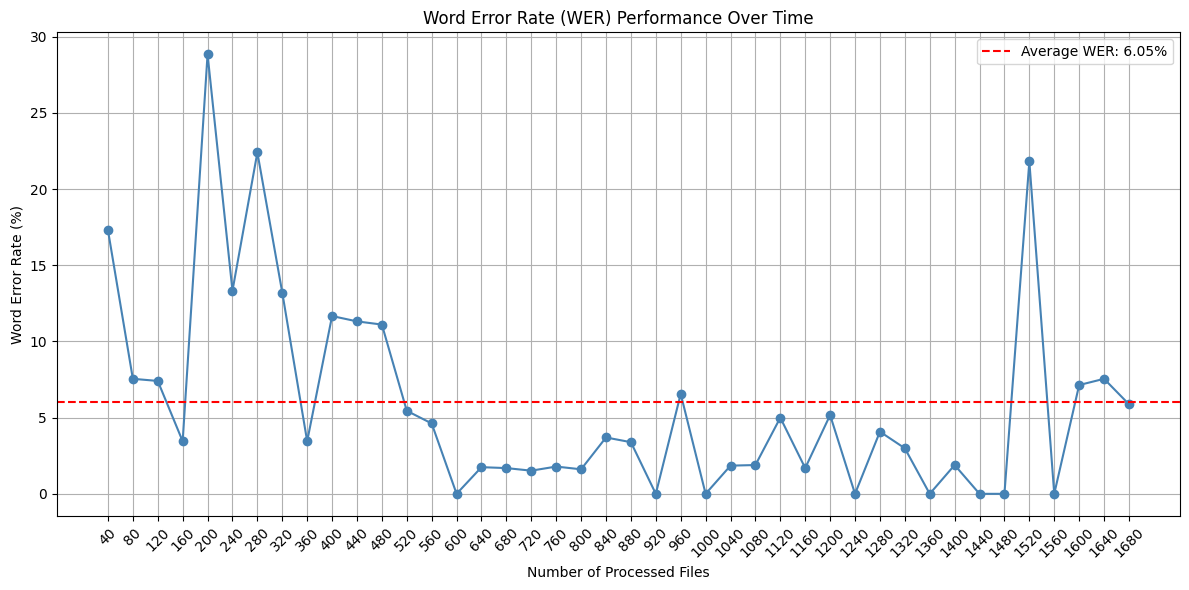

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
files_processed = np.arange(40, 1681, 40)
wer_values = [17.31, 7.55, 7.41, 3.45, 28.85, 13.33, 22.41, 13.21, 3.45, 11.67, 11.32,
              11.11, 5.45, 4.62, 0.00, 1.75, 1.69, 1.52, 1.79, 1.61, 3.70, 3.39, 0.00, 6.56,
              0.00, 1.85, 1.89, 5.00, 1.69, 5.17, 0.00, 4.08, 2.99, 0.00, 1.89, 0.00, 0.00, 21.82,
              0.00, 7.14, 7.55, 5.88]

# Create figure and plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(files_processed, wer_values, color='#4682B4', marker='o', linestyle='-')
ax.axhline(y=6.05, color='r', linestyle='--', label='Average WER: 6.05%')  # Add average WER line

ax.set_xlabel('Number of Processed Files')
ax.set_ylabel('Word Error Rate (%)')
ax.set_title('Word Error Rate (WER) Performance Over Time')
ax.set_xticks(files_processed)
ax.set_xticklabels(files_processed, rotation=45)
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


------------ ------ ------ ------ Evaluation of the Translation model ------ ------ ------ -----------  

In [ ]:
import os
import nltk
from nltk import word_tokenize
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score

nltk.download('wordnet')
nltk.download('punkt')
# Function to load data from a file
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = [line.strip() for line in file if line.strip()]
    return lines

# Function to evaluate translations
def evaluate_translations(references, candidates):
    # Tokenizing the reference and candidate sentences
    tokenized_refs = [[word_tokenize(ref)] for ref in references]
    tokenized_cands = [word_tokenize(cand) for cand in candidates]

    # Calculate BLEU score
    bleu_score = corpus_bleu([[ref] for ref in references], candidates)
    print("BLEU Score:", bleu_score)

    # Calculate METEOR score
    meteor_scores = [meteor_score(ref, cand) for ref, cand in zip(tokenized_refs, tokenized_cands)]
    average_meteor_score = sum(meteor_scores) / len(meteor_scores)
    print("Average METEOR Score:", average_meteor_score)

# Paths to the dataset
punjabi_test_path = '/content/drive/MyDrive/test.pan_Guru'
english_ref_path = '/content/drive/MyDrive/test.eng_Latn'

# Load test data
punjabi_texts = load_data(punjabi_test_path)
english_refs = load_data(english_ref_path)

# Translate Punjabi texts
translated_texts = batch_translate(punjabi_texts, "pan_Guru", "eng_Latn", indic_en_model, indic_en_tokenizer, ip, untranslated_words)

# Evaluate translations
evaluate_translations(english_refs, translated_texts)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


BLEU Score: 0.6975766483838673
Average METEOR Score: 0.6846251287686693


------------ ------ ------ ------ Visualizing results of the Translation model ------ ------ ------ -----------  

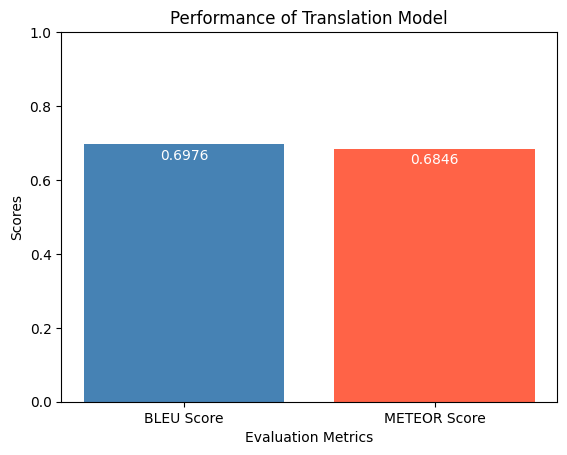

In [ ]:
import matplotlib.pyplot as plt

# Metrics data
metrics = ['BLEU Score', 'METEOR Score']
scores = [0.6976, 0.6846]

colors = ['#4682B4', '#FF6347']

fig, ax = plt.subplots()
# Creating bars
bars = ax.bar(metrics, scores, color=colors)

ax.set_xlabel('Evaluation Metrics')
ax.set_ylabel('Scores')
ax.set_ylim(0, 1)
ax.set_title('Performance of Translation Model')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval - 0.05, round(yval, 4), ha='center', va='bottom', color='white')

plt.show()


------------ ------ ------ ------ Evaluating latency of the translation model ------ ------ ------ -----------  

In [ ]:
import time

def measure_performance(translator_func, texts, iterations=1):
    start_time = time.time()
    for _ in range(iterations):
        results = [translator_func(text) for text in texts]
    end_time = time.time()

    total_time = end_time - start_time
    latency = total_time / len(texts) / iterations
    throughput = len(texts) * iterations / total_time

    return latency, throughput, results

latency, throughput, translations = measure_performance(
    lambda x: batch_translate([x], "pan_Guru", "eng_Latn", indic_en_model, indic_en_tokenizer, ip, untranslated_words),
    punjabi_texts[:10],  # Small subset for quick test
    iterations=5
)

print(f"Average Latency: {latency:.3f} seconds per translation")
print(f"Throughput: {throughput:.3f} translations per second")


Average Latency: 0.416 seconds per translation
Throughput: 2.405 translations per second


------------ ------ ------ ------ Evaluating the Summarization model ------ ------ ------ -----------  

In [ ]:
from datasets import load_dataset, load_metric

# Load the CNN/DailyMail dataset (test split for evaluation)
dataset = load_dataset('cnn_dailymail', '3.0.0', split='test[:1%]')  # Load a small sample for quick evaluation

# Extract articles and reference summaries
articles = dataset['article'][:10]  # Extracting a small sample for demonstration
reference_summaries = dataset['highlights'][:10]  # Corresponding reference summaries

# Generate summaries using the provided summarization pipeline
def generate_summaries_with_pipeline(summarization_pipe, texts):
    """
    Generate summaries using the provided summarization pipeline.

    :param summarization_pipe: Summarization pipeline object
    :param texts: List of texts to summarize
    :return: List of generated summaries
    """
    summaries = []
    for text in texts:
        # Using the summarization pipeline to generate summaries
        result = summarization_pipe(text, max_length=100, min_length=30, do_sample=False)
        summaries.append(result[0]['generated_text'])  # Extract the summary text from the result
    return summaries

# Generate summaries using the pipeline
generated_summaries = generate_summaries_with_pipeline(summarization_pipe, articles)

# Load the ROUGE metric
rouge = load_metric("rouge")

# Function to calculate ROUGE scores
def calculate_rouge(reference_texts, generated_texts):
    """
    Calculate ROUGE scores between reference and generated summaries.

    :param reference_texts: List of reference summaries (ground truth)
    :param generated_texts: List of generated summaries from the model
    :return: Dictionary with ROUGE scores
    """
    results = rouge.compute(predictions=generated_texts, references=reference_texts)

    # Print out ROUGE scores
    print(f"ROUGE-1: {results['rouge1'].mid}")
    print(f"ROUGE-2: {results['rouge2'].mid}")
    print(f"ROUGE-L: {results['rougeL'].mid}")

    return results

# Calculate ROUGE scores for the generated summaries
rouge_scores = calculate_rouge(reference_summaries, generated_summaries)


ROUGE-1: Score(precision=0.33230840171738496, recall=0.47638495309619944, fmeasure=0.38461426731289805)
ROUGE-2: Score(precision=0.1419416187037026, recall=0.2133801614008114, fmeasure=0.1679652065852767)
ROUGE-L: Score(precision=0.23899876067890338, recall=0.3429409858227628, fmeasure=0.2749830814708363)


------------ ------ ------ ------ Visualizing results of the Summarization model ------ ------ ------ -----------  

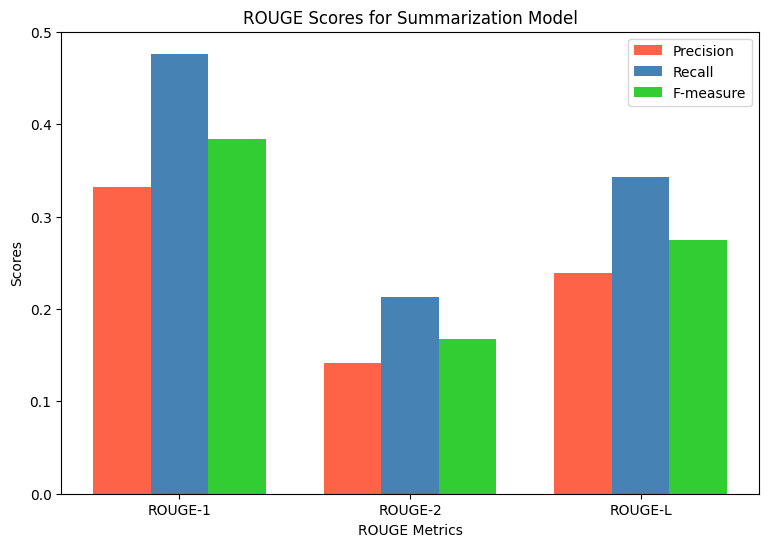

In [ ]:
import matplotlib.pyplot as plt

data = {
    'Precision': [0.3323, 0.1419, 0.2390],
    'Recall': [0.4764, 0.2134, 0.3429],
    'F-measure': [0.3846, 0.1680, 0.2750]
}

# ROUGE metrics labels
rouge_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

# Dynamic colors for each ROUGE metric
colors = ['#FF6347', '#4682B4', '#32CD32']  # Tomato, Steel Blue, Lime Green

fig, ax = plt.subplots(figsize=(9, 6))
# Creating bar groups
bar_width = 0.25
index = range(len(data['Precision']))

for i, (metric, values) in enumerate(data.items()):
    ax.bar([x + bar_width*i for x in index], values, bar_width, label=metric, color=colors[i])

ax.set_xlabel('ROUGE Metrics')
ax.set_ylabel('Scores')
ax.set_title('ROUGE Scores for Summarization Model')
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(rouge_labels)
ax.legend()

plt.show()


------------ ------ ------ ------ Format the result of the Translation model ------ ------ ------ -----------  

In [ ]:
def correct_punctuation_spacing(text):
    # Correct spacing around punctuation and quotes
    text = re.sub(r"\s*([,.;?!])", r"\1", text)  # Removes space before punctuation
    text = re.sub(r"\s*([\"'])\s*", r"\1", text)  # Space before opening quote
    text = re.sub(r"([\"'])\s*", r"\1", text)  # No space after closing quote
    text = re.sub(r"\s{2,}", " ", text)  # Replace multiple spaces with a single space
    text = re.sub(r"\b[i]\b", "I", text)  # Replace single-letter 'i' with uppercase 'I'
    return text.strip()

------------ ------ ------ ------ Using Flask for the backend APIs and setting up a web server using ngrok ------ ------ ------ -----------  

In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok
import soundfile as sf
import numpy as np
from transformers import pipeline
import re

app = Flask(__name__)
CORS(app)

@app.route('/upload', methods=['POST'])
def upload_file():
    if 'file' not in request.files:
        return jsonify({"error": "No file part"}), 400
    file = request.files['file']
    if file.filename == '':
        return jsonify({"error": "No selected file"}), 400

    print("Received file:", file.filename)

    # Process the audio file
    with sf.SoundFile(file) as audio_file:
        audio = audio_file.read(dtype='float32')
        sample_rate = audio_file.samplerate

    # Ensure the audio is in the correct shape for the model
    audio = np.array(audio, dtype=np.float32)

    # Perform ASR
    asr_output = pipe(audio, chunk_length_s=20, stride_length_s=(4, 4))
    transcription = asr_output['text']
    print("Transcription:", transcription)

    # Perform translation
    sents = [transcription]
    translations = batch_translate(sents, "pan_Guru", "eng_Latn", indic_en_model, indic_en_tokenizer, ip, untranslated_words)
    translated_text = correct_punctuation_spacing(translations[0])
    print("Translated Text:", translated_text)

    # Perform summarization
    summary = summarization_pipe(translated_text, max_length=140, min_length=60, do_sample=False)[0]['generated_text']
    print("Summary:", summary)

    return jsonify({"transcription": transcription, "translation": translated_text, "summary": summary})

# Authenticate ngrok
authtoken = "2kKeHHHEgSVWiXRlNDJjsjYfOID_4VsX7mfdLjbjNyy66b7Pa"
ngrok.set_auth_token(authtoken)

# Run the Flask app with ngrok
port = 5000
public_url = ngrok.connect(port)
print(f"Public URL: {public_url}")
app.run(port=port)


Public URL: NgrokTunnel: "https://b95c-104-196-227-156.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


Received file: Recording.wav
Transcription: ਹੈਲੋ ਮੇਰੀ ਜ਼ਿੰਦਗੀ ਵਿੱਚ ਬਹੁਤ ਔਖਾ ਸਮਾਂ ਹੈ ਮੇਰਾ ਹਸਬੈਂਡ ਮੈਨੂੰ ਬਹੁਤ ਕੰਟਰੋਲ ਕਰਦਾ ਹੈ ਉਸ ਨੇ ਮੈਨੂੰ ਮੇਰੇ ਸਾਰੇ ਦੋਸਤਾਂ ਤੋਂ ਵੱਖ ਕਰ ਦਿੱਤਾ ਹੈ ਮੈਂ ਹੁਣ ਕਿਸੇ ਨਾਲ ਵੀ ਗੱਲ ਨਹੀਂ ਕਰ ਸਕਦੀ ਮੇਰੇ ਕੋਲ ਪੈਸੇ ਵੀ ਨਹੀਂ ਹਨ ਇਸ ਲਈ ਮੈਂ ਉਸ ਨੂੰ ਛੋੜਨ ਦਾ ਵੀ ਸੋਚ ਨਹੀਂ ਸਕਦੀ ਮੈਂ ਰੋਜ ਸਿਮਰਨ ਕਰਦੀ ਹਾਂ ਆਈ ਆਸਕ ਗੌਡ ਫੋਰ ਸਟ੍ਰੈਂਥ ਐਵਰੀ ਡੇ ਤੁਸੀਂ ਦੱਸੋ ਮੈਂ ਤੁਸੀਂ ਮੇਰੀ ਕਿਸ ਤਰ੍ਹਾਂ ਮਦਦ ਕਰ ਸਕਦੇ ਹੋ
Original batch: ['ਹੈਲੋ ਮੇਰੀ ਜ਼ਿੰਦਗੀ ਵਿੱਚ ਬਹੁਤ ਔਖਾ ਸਮਾਂ ਹੈ ਮੇਰਾ ਹਸਬੈਂਡ ਮੈਨੂੰ ਬਹੁਤ ਕੰਟਰੋਲ ਕਰਦਾ ਹੈ ਉਸ ਨੇ ਮੈਨੂੰ ਮੇਰੇ ਸਾਰੇ ਦੋਸਤਾਂ ਤੋਂ ਵੱਖ ਕਰ ਦਿੱਤਾ ਹੈ ਮੈਂ ਹੁਣ ਕਿਸੇ ਨਾਲ ਵੀ ਗੱਲ ਨਹੀਂ ਕਰ ਸਕਦੀ ਮੇਰੇ ਕੋਲ ਪੈਸੇ ਵੀ ਨਹੀਂ ਹਨ ਇਸ ਲਈ ਮੈਂ ਉਸ ਨੂੰ ਛੋੜਨ ਦਾ ਵੀ ਸੋਚ ਨਹੀਂ ਸਕਦੀ ਮੈਂ ਰੋਜ ਸਿਮਰਨ ਕਰਦੀ ਹਾਂ ਆਈ ਆਸਕ ਗੌਡ ਫੋਰ ਸਟ੍ਰੈਂਥ ਐਵਰੀ ਡੇ ਤੁਸੀਂ ਦੱਸੋ ਮੈਂ ਤੁਸੀਂ ਮੇਰੀ ਕਿਸ ਤਰ੍ਹਾਂ ਮਦਦ ਕਰ ਸਕਦੇ ਹੋ']
Batch after custom preprocessing: ['ਹੈਲੋ ਮੇਰੀ ਜ਼ਿੰਦਗੀ ਵਿੱਚ ਬਹੁਤ ਔਖਾ ਸਮਾਂ ਹੈ ਮੇਰਾ ਹਸਬੈਂਡ ਮੈਨੂੰ ਬਹੁਤ ਕੰਟਰੋਲ ਕਰਦਾ ਹੈ ਉਸ ਨੇ ਮੈਨੂੰ ਮੇਰੇ ਸਾਰੇ ਦੋਸਤਾਂ ਤੋਂ ਵੱਖ ਕਰ ਦਿੱਤਾ ਹੈ ਮੈਂ ਹੁਣ ਕਿਸੇ ਨਾਲ ਵੀ ਗੱਲ ਨਹੀਂ ਕਰ ਸਕਦੀ ਮੇਰੇ ਕੋਲ ਪੈਸੇ ਵੀ ਨਹੀਂ ਹਨ ਇਸ ਲਈ ਮੈਂ ਉਸ ਨੂੰ ਛੋੜਨ ਦਾ ਵੀ ਸੋਚ ਨਹੀਂ 

INFO:werkzeug:127.0.0.1 - - [29/Aug/2024 14:03:07] "POST /upload HTTP/1.1" 200 -


Summary: My husband controls me a lot. He has separated me from all my friends. I meditate every day. I don't have money and meditate for strength every day, but she doesn't want to leave her husband. She wants someone to help her, but doesn't know how to do it.
